# Earth Engine for gathering data

Google Earth Engine is a powerful tool for geospatial data analysis. Here, we will discuss how to use its Python API for gathering data from Landsat, Sentinel, and NAIP imagery.

To start off with, request access to Google Earth Engine at: [](https://earthengine.google.com/). This may take some time. Once approved, install the Python API and get credentials for using the API following [these instructions](https://developers.google.com/earth-engine/guides/python_install-conda#mac_6). Be sure to try out the test code they suggest to make sure Earth Engine is running successfully):

In [1]:
import numpy as np

In [2]:
import ee

# Initialize the Earth Engine module.
ee.Initialize()

If the above code yields output, you'll know you're ready for to go!

## Selecting imagery



In [3]:
from geetools import batch

def download_S2_toLocal(bbox, name, scale=1):
    """
    downloads Sentinel 2 imagery from the specified bounding box and saves it as `name`
    """
    AOI = ee.Geometry.Rectangle(list(bbox), "EPSG:4326", False)

    collection = (
        ee.ImageCollection("COPERNICUS/S2_SR")
        .filterDate('2020-10-01', '2020-10-10')
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20))
        .filterBounds(AOI)
        .select(['B2', 'B3', 'B4'])
    )

    image = ee.Image(collection.mosaic()).clip(AOI)
    batch.image.toLocal(image, name, scale=scale, region=AOI)
    return collection

# center of image (base of plant)
x = 33.6319
y = -87.0597

# lat long of image
# will vary based on the surface of the earth
lat = [x-0.004, x+0.004]
lon = [y-0.004, y+0.004]
bbox = [lon[0], lat[0], lon[1], lat[1]]
name = 's2sample'
image = download_S2_toLocal(bbox, name, scale=1)

In [142]:
# All metadata.
# print('All metadata:')
print(image.getInfo())
216.30651869036-180

{'type': 'ImageCollection', 'bands': [], 'id': 'COPERNICUS/S2_SR', 'version': 1634498085776133, 'properties': {'date_range': [1490659200000, 1634342400000], 'period': 0, 'system:visualization_0_min': '0.0', 'type_name': 'ImageCollection', 'keywords': ['copernicus', 'esa', 'eu', 'msi', 'reflectance', 'sentinel', 'sr'], 'system:visualization_0_bands': 'B4,B3,B2', 'thumb': 'https://mw1.google.com/ges/dd/images/COPERNICUS_S2_SR_thumb.png', 'description': '<p>Sentinel-2 is a wide-swath, high-resolution, multi-spectral\nimaging mission supporting Copernicus Land Monitoring studies,\nincluding the monitoring of vegetation, soil and water cover,\nas well as observation of inland waterways and coastal areas.</p><p>The Sentinel-2 L2 data are downloaded from scihub. They were\ncomputed by running sen2cor. WARNING: ESA did not produce L2 data\nfor all L1 assets, and earlier L2 coverage is not global.</p><p>The assets contain\n12 UINT16 spectral bands representing SR scaled by 10000 (unlike in L1 d

36.30651869036001

In [5]:
import zipfile
path_to_zip_file = 's2sample.zip'
directory_to_extract_to = 's2sample'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [6]:
import rasterio

def stack_bands_s2(name, outname):
    file_list = [name + '.B4.tif', name + '.B3.tif', name + '.B2.tif']

    # Read metadata of first file
    with rasterio.open(file_list[0]) as src0:
        meta = src0.meta

    # Update meta to reflect the number of layers
    meta.update(count = len(file_list))

    # Read each layer and write it to stack
    with rasterio.open(outname, 'w', **meta) as dst:
        for id, layer in enumerate(file_list, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

outname = "stacked_s2_sample.tif"
stack_bands_s2('s2sample/download',outname)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


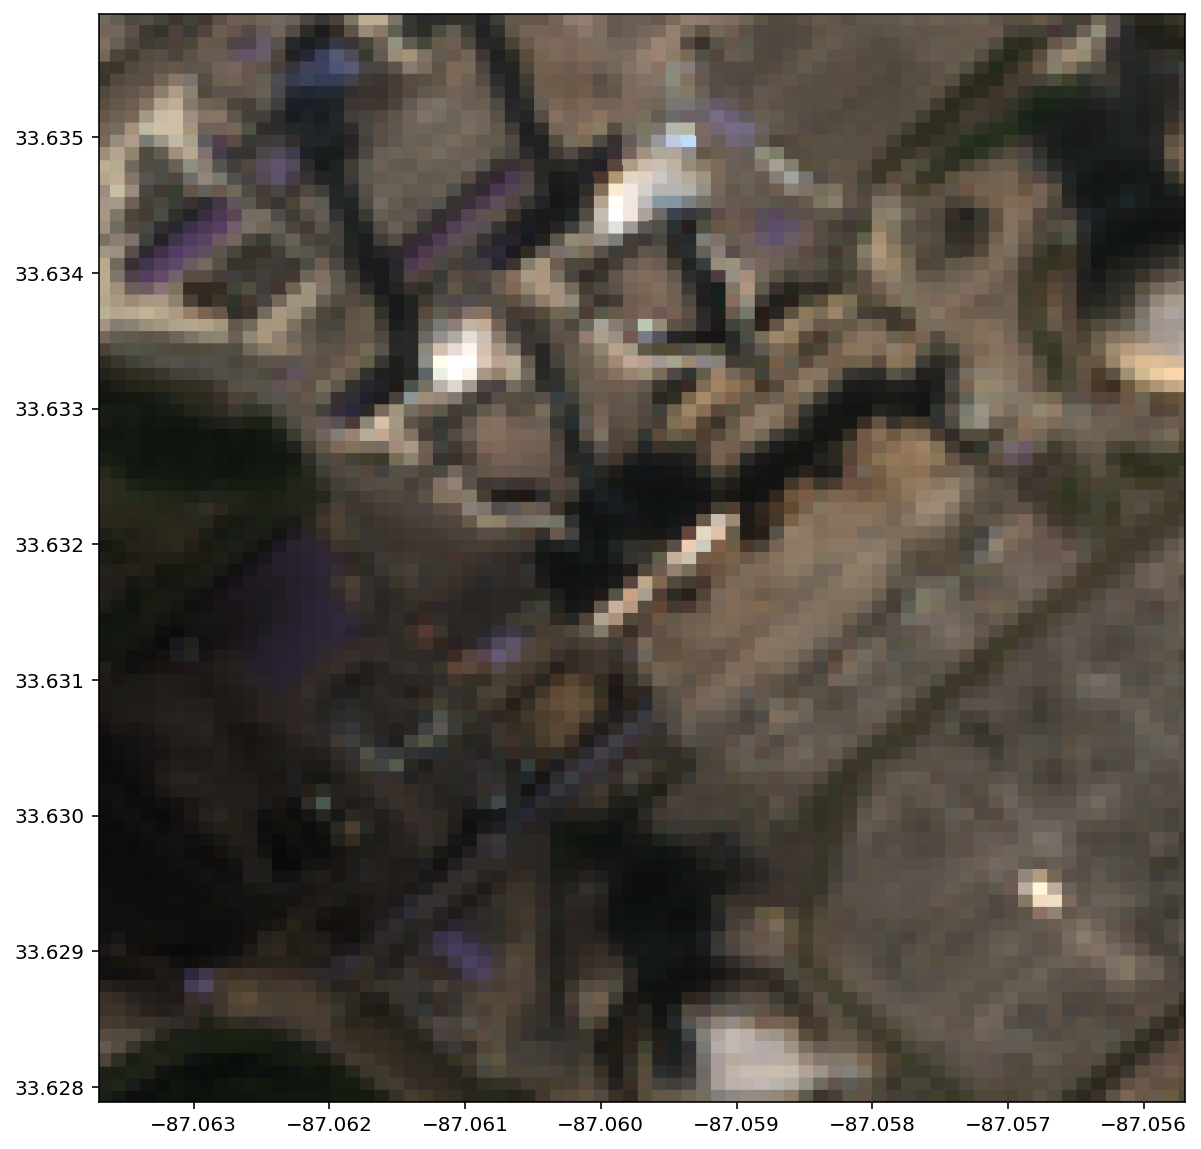

In [7]:
# Plot the example
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from rasterio.plot import show

fig, ax = plt.subplots(num='main', figsize=(10,10))

from rasterio.plot import show
data = rasterio.open(outname)

# show(data.read([1,2,3]).astype('float')/4096, transform=data.transform, ax=ax)
show(data.read([1,2,3]).astype('float')/4096, transform=data.transform, ax=ax)
plt.savefig(r'miller.jpg')

# show(data.read([1,2,3]).astype('float')/255, transform=data.transform, ax=ax)

## Load Image as NumPy Array

In [81]:
# load image as numpy array
with rasterio.open('stacked_s2_sample.tif') as ds:
    img_arr = ds.read()  # read all raster values
img_arr = np.moveaxis(img_arr, 0, -1)

In [82]:
img_arr.shape
# try numpy swap axis, use this --> *move axis, roll axis

(892, 891, 3)

In [146]:
import math

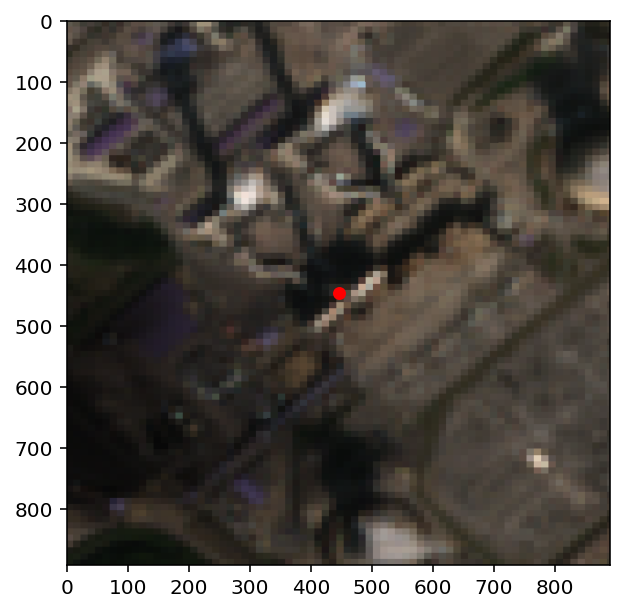

In [153]:
# true color of averaged image?
plt.figure(figsize=(5, 5))
plt.imshow(img_arr/4905)
plt.scatter(891/2,892/2, c='red', s=30)
plt.show()

### Convert image to grayscale?

In [89]:
# take average of each band -- create grayscale image
img_arr_bw = np.average(img_arr, weights=[0.1140, 0.5870, 0.2989], axis=2)

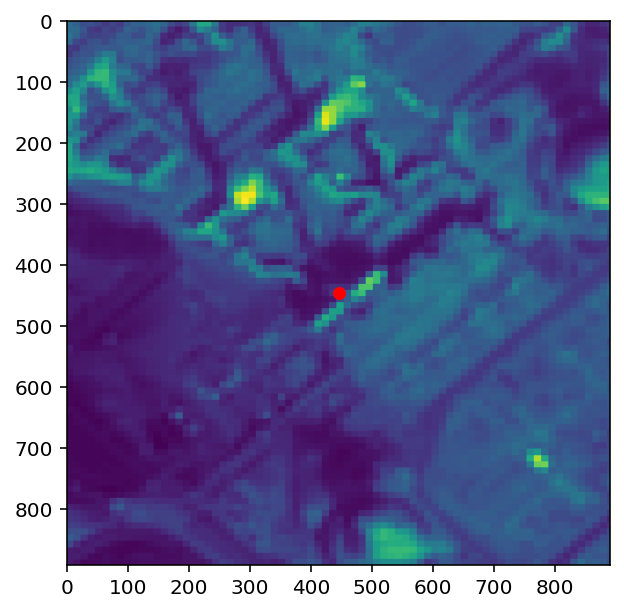

In [12]:
# true color of averaged image?
plt.figure(figsize=(5, 5))
plt.imshow(img_arr_bw)
plt.scatter(891/2,892/2, c='red', s=30)
plt.show()

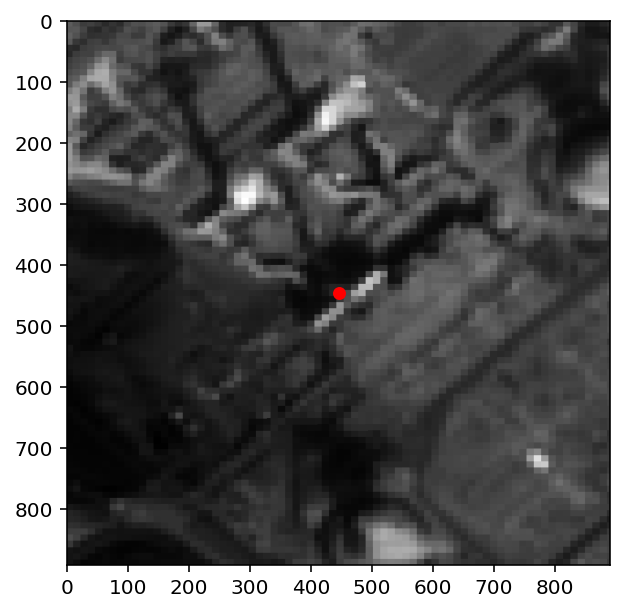

In [13]:
# set to grayscale
plt.figure(figsize=(5, 5))
plt.imshow(img_arr_bw, cmap='gray')
plt.scatter(891/2,892/2, c='red', s=30)
plt.show()

In [14]:
# normalize by largest value in array
img_arr_bw_norm = img_arr_bw/4095

In [15]:
# select threshold
img_seg = np.where(img_arr_bw_norm > 0.24, 0, 1)

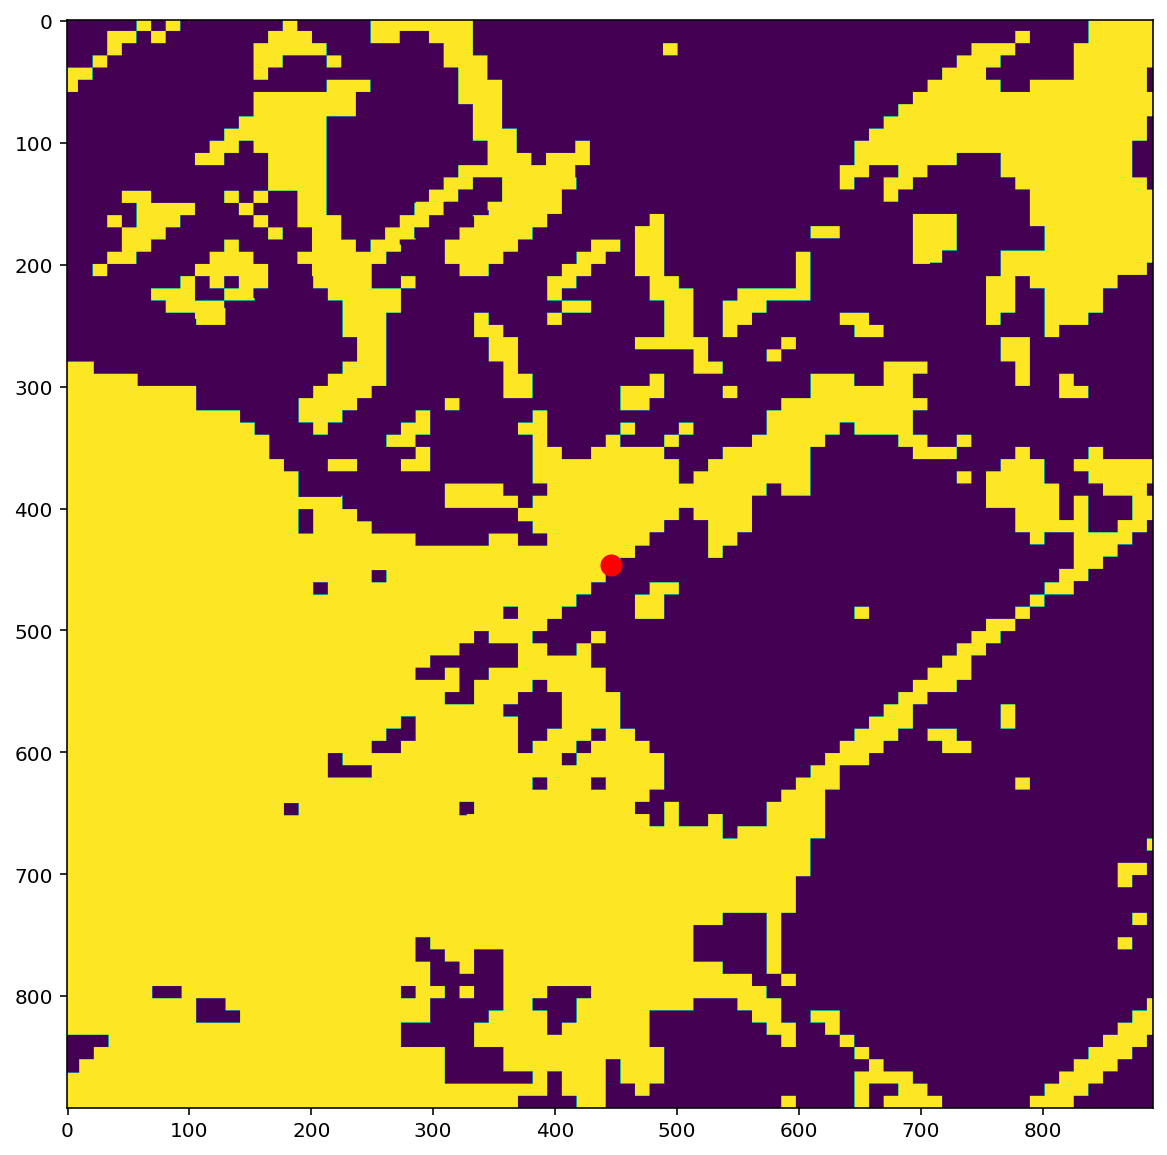

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(img_seg)
plt.scatter(891/2,892/2, c='red', s=100)
plt.show()

#### Crop Image

In [17]:
img_seg.shape

(892, 891)

In [18]:
img_seg_crop = img_seg[215:446, 300:447]

In [19]:
img_seg_crop.shape

(231, 147)

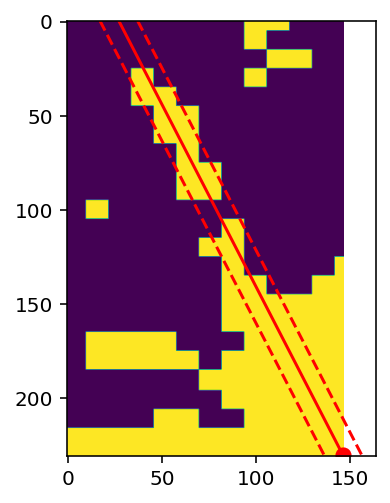

In [181]:
angle = 90+abs(180-158.980095438294)

# plt.figure(figsize=(10, 10))
plt.imshow(img_seg_crop)

# plot base of power plant
plt.scatter(146, 230, c='red', s=50)

# angle lines
plt.axline((136,230), slope=math.radians(angle), color='red', 
           label='axline', linestyle='dashed')
plt.axline((146,230), slope=math.radians(angle), color='red', 
           label='axline')
plt.axline((156,230), slope=math.radians(angle), color='red', 
           label='axline', linestyle='dashed')

plt.show()

## Connected components (Gaussian Filtering + Connected Components)

**Note: Ignore gaussian filtering when image is only 1s & 0s)

In [21]:
from PIL import Image
from scipy import ndimage

In [22]:
blur_radius = 0.1
threshold = 0.25

In [23]:
# smooth the image (to remove small objects)
# imgf = ndimage.gaussian_filter(img_seg_crop, blur_radius)

In [24]:
threshold = 0.5

# find connected components
labeled, nr_objects = ndimage.label(img_seg_crop > threshold) 
print("Number of objects is {}".format(nr_objects))

Number of objects is 7


In [183]:
nr_objects

7

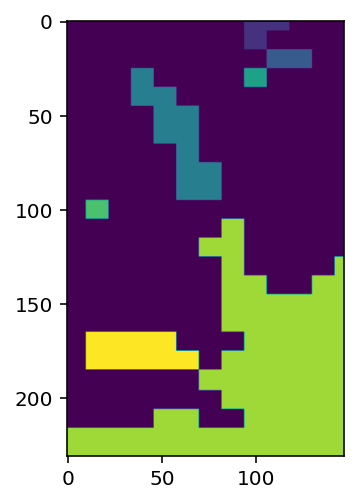

In [25]:
plt.imshow(labeled)
plt.show()

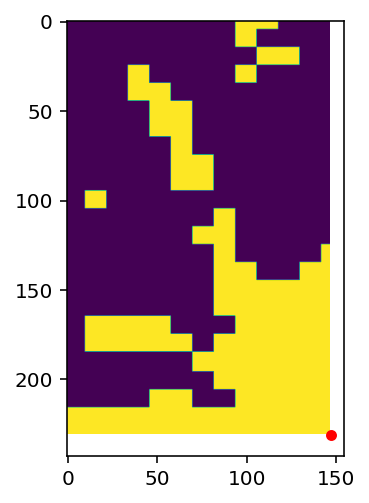

In [26]:
# try for dark color variations
img_seg_dark = np.where(img_arr_bw_norm > 0.24, 0, img_arr_bw_norm)
img_seg_crop_dark = img_seg[215:446, 300:447]

plt.imshow(img_seg_crop_dark)
plt.scatter(147, 231, c='red', s=20)
plt.show()

In [27]:
blur_radius = 0.1
threshold = 0.10

# smooth the image (to remove small objects)
imgf = ndimage.gaussian_filter(img_seg_crop_dark, blur_radius)

In [28]:
# find connected components
labeled, nr_objects = ndimage.label(imgf > threshold) 
print("Number of objects is {}".format(nr_objects))

Number of objects is 7


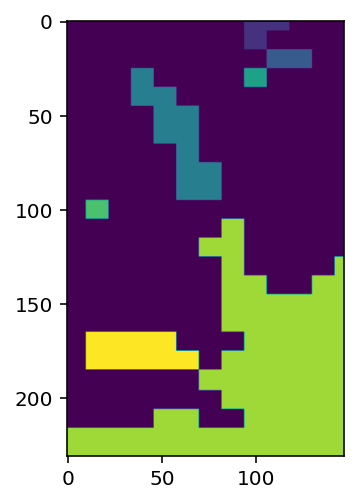

In [29]:
# look at potential angle range
# key point detection
plt.imshow(labeled)
plt.show()

## Segment shadow in image with k-means clustering

In [30]:
import cv2

In [43]:
img_arr_transpose = np.transpose(img_arr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


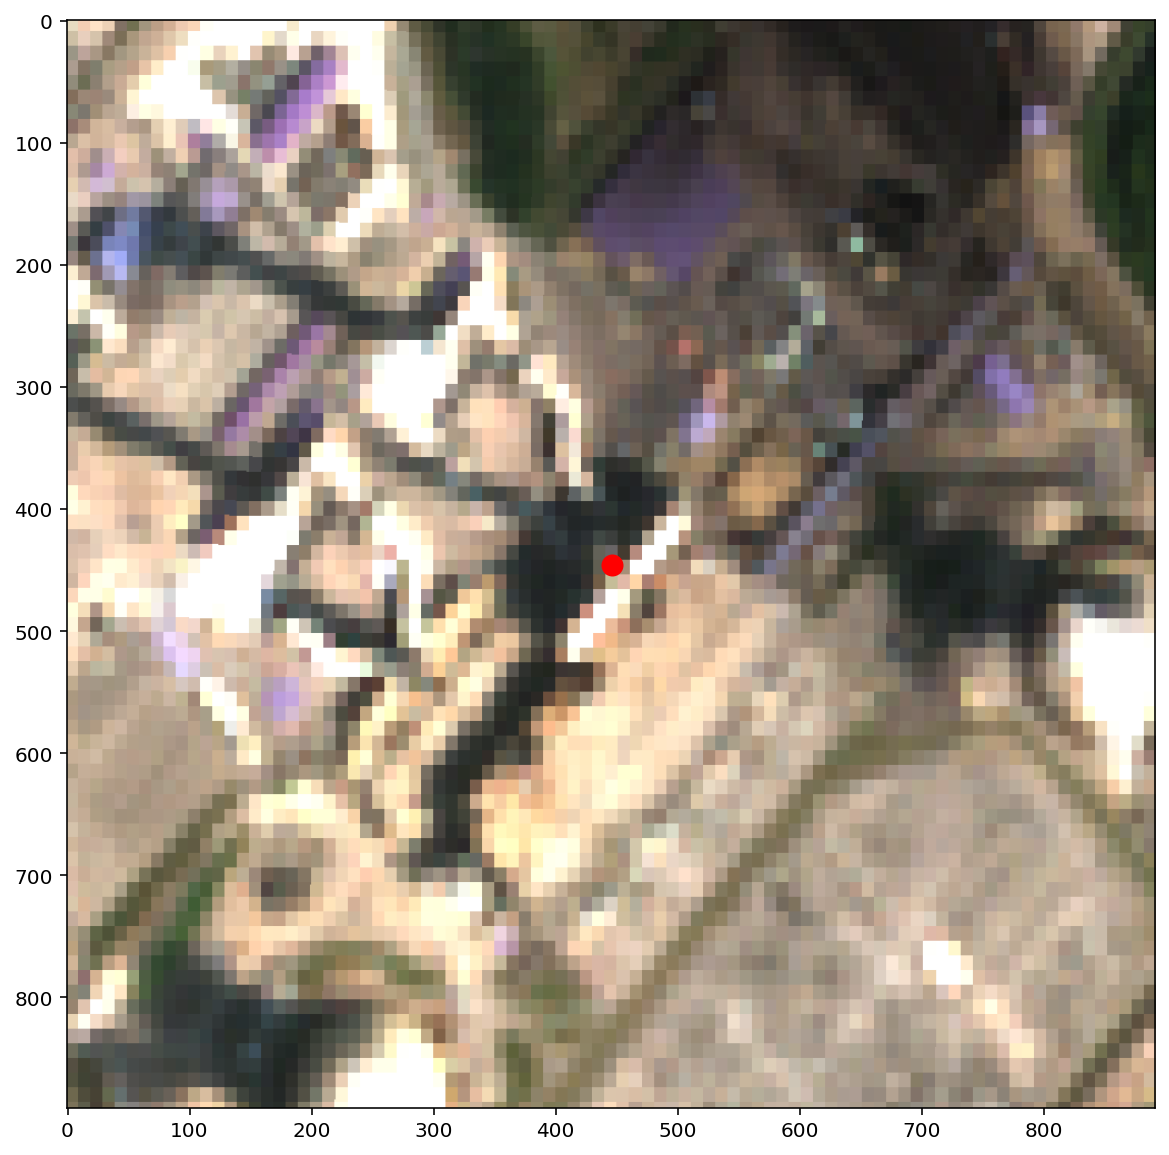

In [44]:
plt.figure(figsize=(10, 10))
plt.imshow(img_arr_transpose/2000)
plt.scatter(892/2,891/2, c='red', s=100)
plt.show()

In [45]:
img_arr_transpose_crop = img_arr_transpose[250:500, 150:500]

In [46]:
# normalize by largest value in array
img_arr_transpose_norm = img_arr_transpose_crop/img_arr_transpose_crop.max()
img_arr_transpose_seg = np.where(img_arr_transpose_norm > 0.24, 0, img_arr_transpose_norm) 

In [47]:
img=cv2.cvtColor(img_arr_transpose_crop,cv2.COLOR_BGR2RGB)

In [48]:
# vectorized = img_arr_transpose_seg.reshape((-1,3))
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)

In [49]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [50]:
K = 3
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

In [51]:
center = np.uint8(center)

In [52]:
res = center[label.flatten()]
result_image = res.reshape((img.shape))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


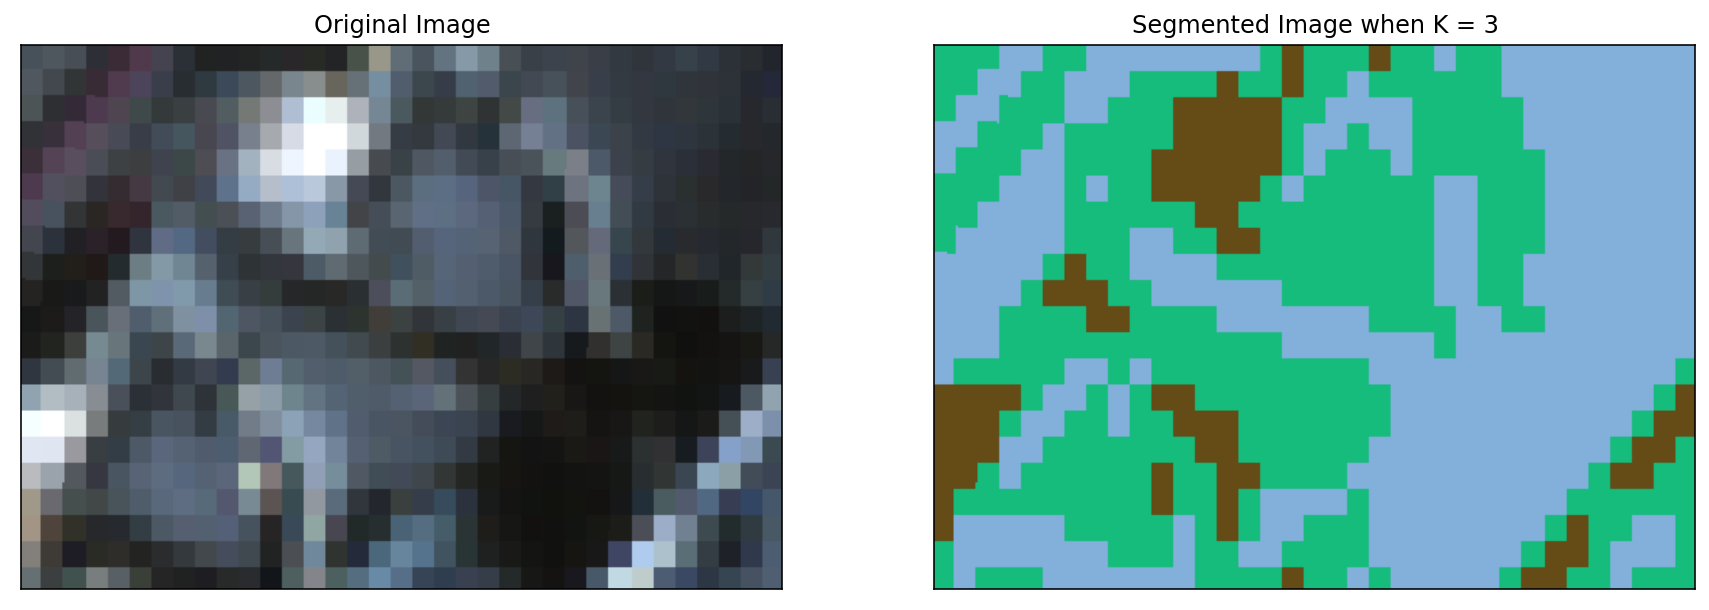

In [53]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img/4095)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

### Mean shift segmentation

In [80]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [129]:
# Estimate bandwith
bandwidth = estimate_bandwidth(img_arr_bw, quantile=0.2, n_samples=100)

In [123]:
shape = img_arr.shape

In [132]:
# Fit Mean Shift with Scikit
meanshift = MeanShift(bandwidth=bandwidth)
meanshift.fit(img_arr_bw)
labels = meanshift.labels_
cluster_centers = meanshift.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

In [94]:
img_arr_ms = meanshift.predict(img_arr_bw)

In [133]:
shape[:2]

(892, 891)

In [134]:
result_image = np.reshape(labels, shape[:2])

ValueError: cannot reshape array of size 892 into shape (892,891)

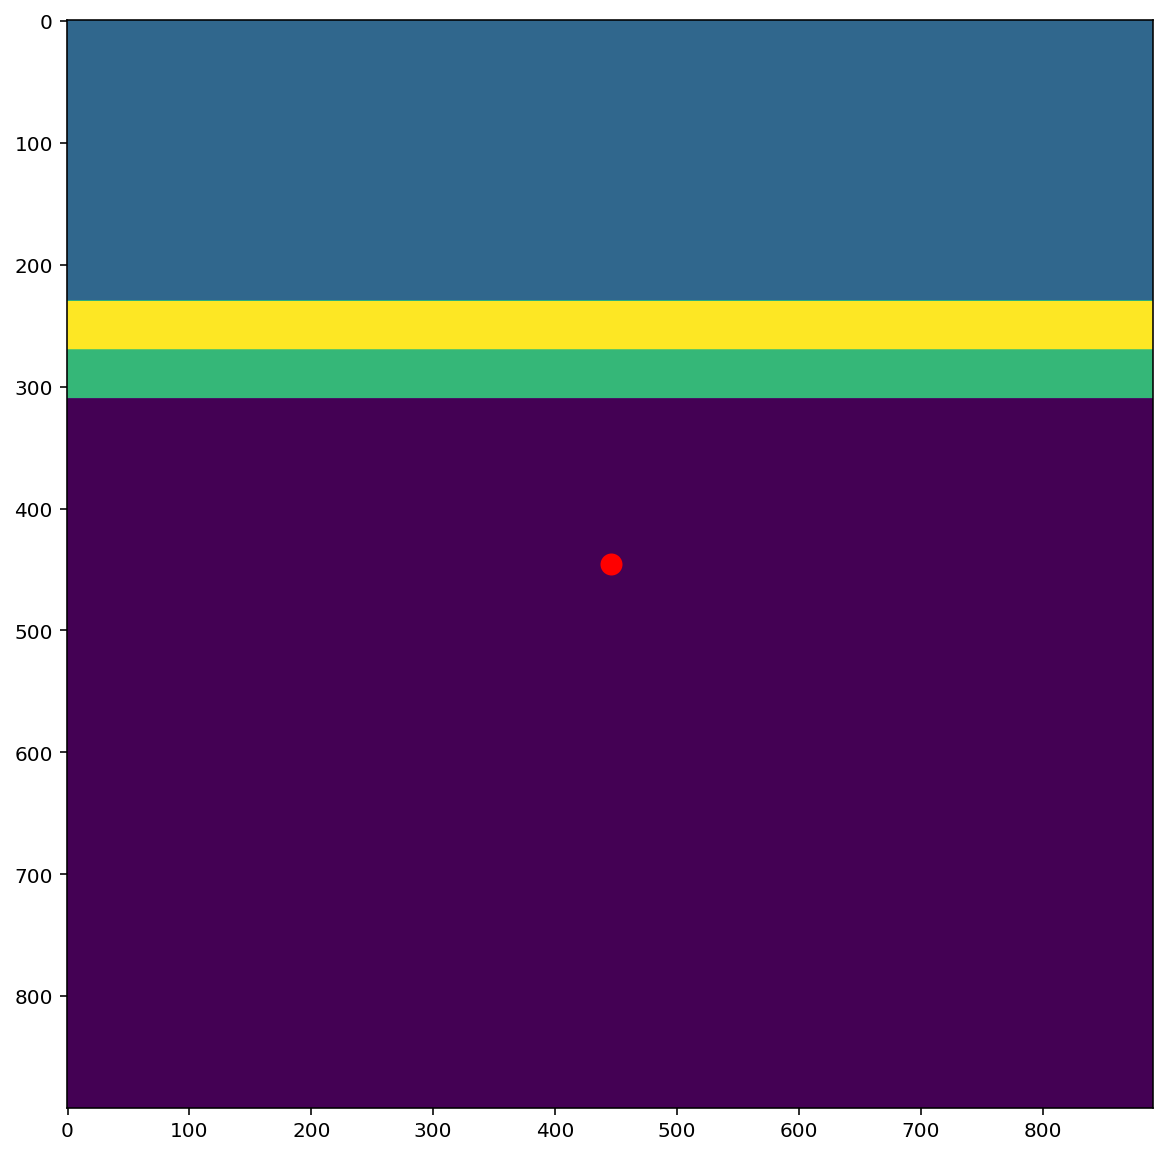

In [137]:
plt.figure(figsize=(10, 10))
plt.imshow(output)
plt.scatter(892/2,891/2, c='red', s=100)
plt.show()